In [222]:
# Import of the packages
import numpy as np
import random as rnd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import math
import scipy.stats as sts

In [223]:
class ParameterValueError(Exception):
    """ Custom exception raised when a parameter has an invalid value."""
    pass

In [224]:
class FailedOptimizationError(Exception):
    """ Custom exception raised when a the optimization process fails."""
    pass

In [225]:
class UntrainedModelError(Exception):
    """ Custom exception raised when an untrained model is called to make predictions."""
    pass

In [283]:
# SVM class
class SVM:
    """ Support Vector Machine (SVM) for regression.
    
    Implementation of SVM for classification with an option to use
    both the original SVM formulation and the alternative v-SVM
    formulation.
    
    Attributes:
        kerType: A string of the type of the desired kernel.
        svmType: A string denoting the SVM type to be used. The string "C" denotes
            the original SVM formulation while the string "V" is used for the 
            alternative v-SVM formulation.
        V: V-variable.
        C: C-variable.
        p: Integer value denoting the degree of the polynomial kernel.
        sigma: Float value denoting the smoothing factor of the Gaussian kernel.
        kappa: Float value denoting the scaling parameter of the sigmoid kernel.
        delta: Float value denoting the translation parameter of the sigmoid kernel.
        bTrained: boolean value which becomes true once the SVM has been trained.
        a: the 'a' lagrangian multipliers of the SVM.
        b: the bias term of the SVM
        X_sv: the input values of the support vectors.
        Y_sv: the output values of the support vectors.
    """

    EPSILON = 1e-10
   
    def __init__(self, kerType = 'poly', svmType = 'C',
                 V = 0.45, C = 1, p = 1, sigma = 1, 
                 kappa = 1, delta = 1):
        """ Initializes the SVM class (constructor).
        
            Raises:
                ParameterValueError: An error occured because a parameter had an
                    invalid value.  
        """
        # Check if the kernel type chosen is valid
        kerTypes = ['linear', 'poly', 'radial', 'sigmoid']
        if kerType not in kerTypes:
            raise ParameterValueError("ParameterValueError: The string " + kerType + \
                                       " does not denote a valid kernel type")
        # Check if the string denoting the svmType has a valid value
        if svmType != 'C' and svmType != 'V':
            raise ParameterValueError('ParameterValueError: ' + svmType, \
                                       " is not a valid SVM type value. Enter 'C' or 'V' as a value. ")
        self.kerType = kerType
        self.svmType = svmType
        self.V = V
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.bTrained = False

    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            The computed kernel value.
        """  
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def lagrange(self, params, y, K):
        """ The lagrangian objective function to be minimized.
        
        Args:
            params: A vector with all the a and a-hat Lagrange multipliers.          
            y: Vector with the true output values.
            K: Matrix with the kernel values computed between each input.
        
        Returns:
            The value of the lagrangian for the given parameters.
        """
        N = np.shape(params)[0]
        a = params.reshape((N,1))
        y = y.reshape((N,1))
        w = np.multiply(a,y)
        if self.svmType == "C":
            L = (1/2) * w.T.dot(K).dot(w) - np.sum(a)
        elif self.svmType == "V":
            L = (1/2) * w.T.dot(K).dot(w) 
        return L
    
    def train(self, X_tr, Y_tr):
        """ SVM training method
        
        Trains the SVM by minimizing the lagrangian function given the
        training input and output samples.
        
        Args:
            X_tr: A matrix with a training input sample in each row.
            Y_tr: A vector with the output values of each input sample
                in X_tr.
        
        Returns:
            None
        
        Raises:
            FailedOptimizationError: An error occured because the optimization
                of the lagrangian failed.
        """
        N_tr = np.shape(X_tr)[0]
        K = np.zeros((N_tr, N_tr))
        for i in range(N_tr):
            for j in range(N_tr):
                K[i,j] = self.kernel(X_tr[i], X_tr[j])
        args = (Y_tr, K)
        
        bounds = []
        if self.svmType == "C":
            for i in range(0, N_tr):
                bounds.append((0,self.C))
        elif self.svmType == "V":
            for i in range(0, N_tr):
                bounds.append((0, 1.0 / N_tr))
        
        def constraint_a(params):
            N = np.shape(params)[0]
            a = params.reshape((N,1))
            y = Y_tr.reshape((N,1))
            return np.sum(a.T.dot(y))
        
        def constraint_b(params):
            N = np.shape(params)[0]
            a = params.reshape((N,1))
            return np.sum(a) - self.V

        if self.svmType == "C":
            cons = {'type':'eq', 'fun': constraint_a}
        elif self.svmType == "V":
            cons = [{'type':'eq', 'fun': constraint_a},
                {'type':'ineq', 'fun' : constraint_b}]

        
        initial = np.ones(N_tr)
        final = optimize.minimize(self.lagrange, initial, args, \
            bounds=bounds, constraints=cons, method='SLSQP', tol = self.EPSILON)
        
        if final.success != True:
            raise FailedOptimizationError("FailedOptimizationError: The optimization was not successful.")
        
        a = final.x[0:N_tr]
        
        if self.svmType == "C":
            m_set_ind = np.logical_and(a > self.EPSILON, a < self.C)
        elif self.svmType == "V":
            m_set_ind = np.logical_and(a > self.EPSILON, a < 1.0 / N_tr)
        s_set_ind = a > self.EPSILON
        
        b_sum = 0
        for n in range(N_tr):
            if m_set_ind[n] == True:
                p_sum = 0
                for m in range(N_tr):
                    if s_set_ind[m] == True:
                        p_sum += a[m]*Y_tr[m]*K[n,m]
                b_sum += Y_tr[n] - p_sum
        b = b_sum / np.sum(m_set_ind)
        
        a = a[s_set_ind]
        X_sv = X_tr[s_set_ind]
        Y_sv = Y_tr[s_set_ind]
        
        self.a = a
        self.b = b
        self.X_sv = X_sv
        self.Y_sv = Y_sv
        self.bTrained = True
        
    def pred(self, X):
        """Predicts the classes for a number of input data
        
        Args:
            X: matrix with input data where each row represents a sample.
            
        Returns:
            y: vector with the predicted class for each input sample.
            
        Raises:
            UntrainedModelError: Error that occurs when this function is called
                before calling the 'train' function.
        """
        
        if self.bTrained == False:
            raise UntrainedModelError("UntrainedModelError: The SVM model has not been trained.")
        
        N_sv = np.shape(self.X_sv)[0]
        N = np.shape(X)[0]
        a = self.a.reshape(N_sv,1)
        Y_sv = self.Y_sv.reshape(N_sv,1)
        w = np.multiply(a, Y_sv)
        K = np.zeros((N_sv, N))
        for i in range(N_sv):
            for j in range(N):
                K[i,j] = self.kernel(self.X_sv[i],X[j])
        y = np.sign(w.T.dot(K) + self.b)
        y = y.reshape(-1)
        return y
    
    def getSV(self):
        return self.X_sv, self.Y_sv

In [284]:
def generateData1(N):
    # Seed the random generator
    np.random.seed(100)

    # Create the class A triplets (10 elements)
    classA = [(rnd.normalvariate(0, 1), rnd.normalvariate(5, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(5, 1), rnd.normalvariate(0, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(5, 1), rnd.normalvariate(10, 1),
               1.0) for i in range(N)]

    # Create the class B triplets (10 elements)
    classB = [(rnd.normalvariate(12, 1), rnd.normalvariate(5, 1),
               -1.0) for i in range(3 * N)]

    # Mix the two classes in the data
    data = classA + classB
    rnd.shuffle(data)
    data = np.array(data)
    x_tr = data[:,0:2]
    y_tr = data[:,2]
    return x_tr, y_tr


def generateData2(N):
    # Seed the random generator
    np.random.seed(100)

    # Create the class A triplets (10 elements)
    classA = [(rnd.normalvariate(-7.5, 1), rnd.normalvariate(-7.5, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(-7.5, 1), rnd.normalvariate(-6, 1),
               1.0) for i in range(N)]

    # Create the class B triplets (10 elements)
    classB = [(rnd.normalvariate(-3.5, 1), rnd.normalvariate(-4,1),
               -1.0) for i in range(2 * N)]

    # Mix the two classes in the data
    data = classA + classB
    rnd.shuffle(data)
    data = np.array(data)
    x_tr = data[:,0:2]
    y_tr = data[:,2]
    return x_tr, y_tr

def generateData3(N):
    # Seed the random generator
    np.random.seed(100)

    # Create the class A triplets (10 elements)
    classA = [(rnd.normalvariate(0, 1), rnd.normalvariate(5, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(12, 1), rnd.normalvariate(-3, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(12, 1), rnd.normalvariate(13, 1),
               1.0) for i in range(N)] + \
             [(rnd.normalvariate(24, 1), rnd.normalvariate(5, 1),
               1.0) for i in range(N)]

    # Create the class B triplets (10 elements)
    classB = [(rnd.normalvariate(12, 1), rnd.normalvariate(5, 1),
               -1.0) for i in range(4 * N)]

    # Mix the two classes in the data
    data = classA + classB
    rnd.shuffle(data)
    data = np.array(data)
    x_tr = data[:,0:2]
    y_tr = data[:,2]
    return x_tr, y_tr

def generateData4(N):
    classA = [(0,1,1.0)]
    classB = [(-1,-1,-1.0),(1,-1,-1.0)]
    data = classA + classB
    data = np.array(data)
    x_tr = data[:,0:2]
    y_tr = data[:,2]
    return x_tr, y_tr


def plotData(x, y):
    # Plot the data
    classA = x[y == 1]
    classB = x[y == -1]

    plt.xlabel('X Axis (No units)')
    plt.ylabel('Y Axis (No units)')

    plt.plot(classA[:,0], classA[:,1], 'bo')
    plt.plot(classB[:,0], classB[:,1], 'ro')

    plt.legend(["Class A","Class B"])
    
    plt.show()



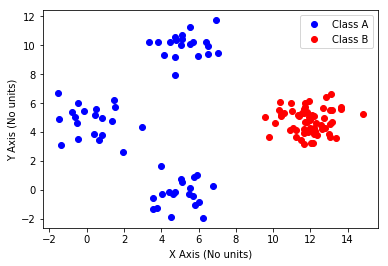

In [307]:
x_tr, y_tr = generateData1(20)
plotData(x_tr, y_tr)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in long_scalars


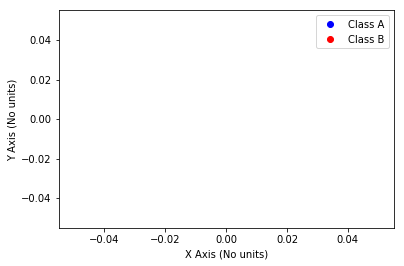

In [319]:
s = SVM(kerType="poly", svmType= "C", V=1, p = 2, sigma = 1)
s.train(X_tr=x_tr, Y_tr=y_tr)
y_pr = s.pred(x_tr)
plotData(x_tr, y_pr)

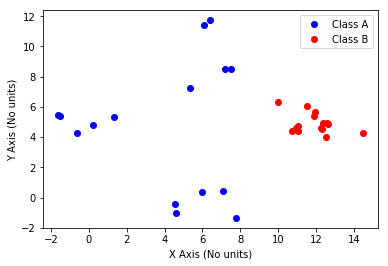